In [1]:
%load_ext autoreload
%autoreload 2

# Generic Viewpoint

In [2]:
import jax
import jax.numpy as jnp
from   jax import jit, vmap
import bayes3d as b3d
import genjax
from   genjax import gen, choice_map, vector_choice_map
from   genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import matplotlib.pyplot as plt
from   matplotlib.collections import LineCollection
import numpy as np
import trimesh
from functools import partial
from pathlib import Path
import os

key = jax.random.PRNGKey(0)
# console = genjax.pretty(show_locals=False)

In [4]:
from jax.scipy.spatial.transform import Rotation

inv       = jnp.linalg.inv
logaddexp = jnp.logaddexp
logsumexp = jax.scipy.special.logsumexp

In [5]:
from xsight.utils import *
from xsight.importance import _importance_sampling, _update, _generate, _simulate, _propose
from xsight.pose import pack_pose, unpack_pose, apply_pose, from_euler, look_at
from xsight.meshes import *
from xsight.plotting import *

In [6]:
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf    = jax.scipy.stats.norm.logpdf
normal_pdf       = jax.scipy.stats.norm.pdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
truncnorm_pdf    = jax.scipy.stats.truncnorm.pdf

In [7]:
def lift_pose(v, z=0.0, pitch=0.0, roll=0.0):
    """Lifts a 2d pose (x,hd) to 3d"""
    x, hd = v[:2], v[2]
    return pack_pose(
        jnp.concatenate([x, jnp.array([z])]),
        from_euler(hd, pitch, roll)
    ) 

In [8]:
CAM_ALONG_X = jnp.array([
    [0,  0, 1],
    [-1, 0, 0],
    [0,  -1, 0]
])

_CAM_ALONG_X = jnp.eye(4)
_CAM_ALONG_X = _CAM_ALONG_X.at[:3,:3].set(CAM_ALONG_X) 

# def look_at(v, roll=0.0):
#     """Imagine you stand on xy-plane and point a camera at a point v in 3d space."""
#     n = jnp.linalg.norm(v)
#     rot   = jnp.arctan2(v[1],v[0])
#     pitch = jnp.arctan2(v[2],n)
#     return from_euler(rot, pitch, roll)


# def lift_pose(v, z=0.0, pitch=0.0, roll=0.0):
#     """Lifts a 2d pose (x,hd) to 3d"""
#     x, hd = v[:2], v[2]
#     return pack_pose(
#         jnp.concatenate([x, jnp.array([z])]),
#         from_euler(hd, pitch, roll)
#     ) 

# 

## Grid

In [9]:
def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

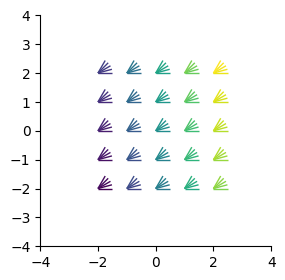

In [10]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 2, ax=ax)
plot_poses(vs, sc, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Renderer and meshes

In [11]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []

for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)

In [12]:
#| Set up the renderer and add the scene mesh
def make_render_function(meshes, w=100, h=100, fx=30, fy=30, far=20, near=0.01):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx=fx, fy=fy,
        cx=w/2 - 0.5, cy=h/2 - 0.5,
        near=near, far=far
    )
    
    b3d.setup_renderer(intrinsics)
    for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)
    b3d.RENDERER.add_mesh_from_file(os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

    def render(cam:"Camera Pose", ps:"Object Poses", inds:"Object indices"): 
        return b3d.RENDERER.render(inv(cam) @ ps , inds)[...,:3]

    return render

In [13]:
_far   = 3.0
_shape = (100,100)
_f = 150
_intr   = dict(w=_shape[1], h=_shape[0], fx=_f, fy=_f, near=0.0001, far=_far)

# _intr_low   = dict(w=_shape[1]//4, h=_shape[0]//4, fx=150//4, fy=150//4, near=0.0001, far=_far)

render   = make_render_function(meshes, **_intr)
# jrender  = jit(render)
# jmrender = jit(vmap(render, (0,None,None)))

help(render)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)
Help on function render in module __main__:

render(cam: 'Camera Pose', ps: 'Object Poses', inds: 'Object indices')



In [14]:
def prep_im(Y, far=_far, eps=1e-6):
    im = np.where(Y[:,:,2]>= _far - eps, jnp.inf, Y[:,:,2])
    return im

## Make Table Scene

[[-5.9604641e-08 -9.9999988e-01 -2.5605528e-08 -9.9999990e+00]
 [-1.0552863e-07  2.5605535e-08 -1.0000000e+00 -4.0692877e-02]
 [ 9.9999994e-01  5.9604652e-08 -1.0552862e-07  2.0000000e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 1.   -0.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [-0.    0.    1.   -0.75]
 [ 0.    0.    0.    1.  ]]


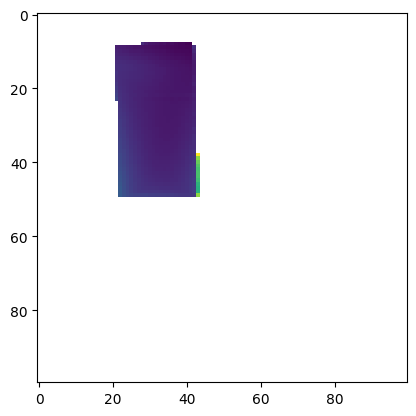

In [25]:
def make_table_scene(inds:"Array of  obj indices", vs:"Array of 2d-pose vecs"):

    table_x = jnp.zeros(3)
    table_r = jnp.eye(3)
    table_pose = pack_pose(table_x, table_r)

    indices = jnp.array([21])
    indices = jnp.concatenate([indices, inds])

    root_poses = jnp.concatenate([table_pose[None,:,:], jnp.zeros((len(vs), 4,4))])
    box_dims   = b3d.RENDERER.model_box_dims[indices]
    parents    = jnp.array([-1])
    parents    = jnp.concatenate([parents, jnp.zeros(len(vs))]).astype(int)
    contact_params = jnp.array([jnp.zeros(3)])
    contact_params = jnp.concatenate([contact_params, vs])
    faces_parents  = jnp.array([2])
    faces_child    = jnp.array([3])
    faces_parents  = jnp.concatenate([faces_parents , jnp.ones(len(vs))], axis=0).astype(int)
    faces_child    = jnp.concatenate([faces_child , 3*jnp.ones(len(vs))], axis=0).astype(int)

    ps = b3d.scene_graph.poses_from_scene_graph(
                root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

    return ps[1:]


# Make a scene (centered at the origin)
_inds = jnp.array([13,2])
_ps = make_table_scene(_inds, jnp.array([[-10.0, 20.0, 0.0*jnp.pi],[-0.075,-0.1,0.*jnp.pi]]))

# Place a camera
cam_x = jnp.array([0.0, 0.0, -.75])
_cam = b3d.transform_from_pos_target_up(cam_x, jnp.zeros(3), jnp.array([0.0,-1.0,0.0]))

_X = render(_cam, _ps, _inds)

print(_ps[0])
print(_cam)
# =====================
plt.imshow(prep_im(_X))

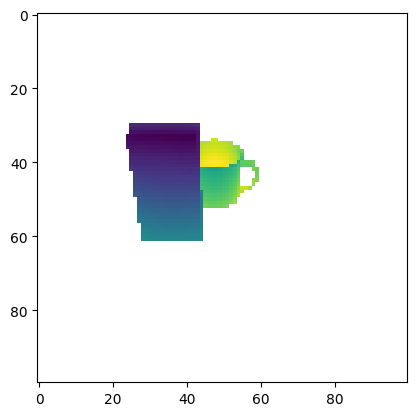

In [16]:
# Make a scene (centered at the origin)
_inds = jnp.array([13,2])
_ps = make_table_scene(_inds, jnp.array([[0.0,0.0,0.5*jnp.pi],[-0.075,-0.1,0.*jnp.pi]]))

# Place a camera
cam_x = jnp.array([0.0, -0.5, -.75])
_cam = b3d.transform_from_pos_target_up(cam_x, jnp.zeros(3), jnp.array([0.0,-1.0,0.0]))

_X = render(_cam, _ps, _inds)

# =====================
plt.imshow(prep_im(_X))

## Generic Viewpoint

In [21]:
def generic_viewpoint(key, cam, n, sig_x, sig_hd):
    """Generates generic camera poses by varying its xy-coordinates and angle (in the xy-plane)."""
    
    # TODO: Make a version that varies rot and pitch and potentially roll.
    
    _, keys = keysplit(key,1,2)

    # Generic position
    xs = sig_x*jax.random.normal(keys[1], (n,3))
    xs = xs.at[0,:].set(0.0)
    xs = xs.at[:,2].set(0.0)

    # Generic rotation
    hds = sig_hd*jax.random.normal(keys[0], (n,))
    hds = hds.at[0].set(0.0)
    rs = vmap(Rotation.from_euler, (None,0))("y", hds)
    rs = Rotation.as_matrix(rs)
    
    # Generic camera poses
    ps = vmap(pack_pose)(xs, rs)
    ps = cam@ps

    # Generic weights
    logps_hd = normal_logpdf(hds, loc=0.0, scale=sig_hd)
    logps_x  = normal_logpdf( xs, loc=0.0, scale=sig_x).sum(-1)
    logps    = logps_hd + logps_x

    return ps, logps


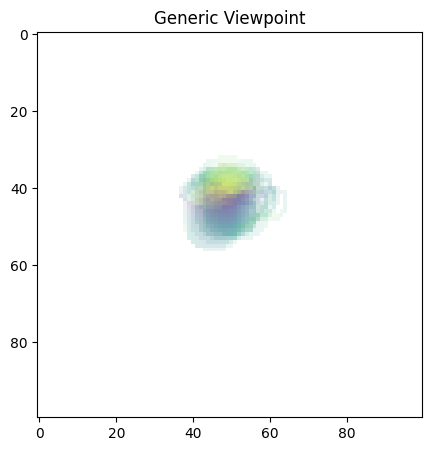

In [22]:
inds = jnp.array([13])
key  = keysplit(key)
generic_cam,_ = generic_viewpoint(key, _cam, n=10, sig_x=0.01, sig_hd=0.01);
Ys = vmap(render, (0,None,None))(generic_cam, _ps[:1], inds)

# ==============================
plt.figure(figsize=(5,5))
plt.title("Generic Viewpoint")
for Y in Ys[:]:
    plt.imshow(prep_im(Y), alpha=0.1)

In [19]:
def generic_imgs(key, cam, ps, indices, n, sig_x, sig_r):
    dps, logps = generic_viewpoint(key, n, sig_x, sig_r)
    Ys  = vmap(render, (0,None,None))(dps@cam, ps, indices)
    return Ys, dps, logps

jgeneric_imgs = jit(generic_imgs, static_argnames=["n"])

In [20]:
# def pose_mat(v):
#     x, hd = v[:2], v[2]
#     return jnp.array([
#         [jnp.cos(hd), - jnp.sin(hd), x[0]],
#         [jnp.sin(hd),   jnp.cos(hd), x[1]],
#         [         0.,            0.,   1.]
# ])

# def pose_vec(m):
#     hd = jnp.artan2(m[1,0],m[0,0])
#     x  = m[:2,2]
#     return jnp.array([m[0,2],m[1,2], hd])

## Generic Contact

In [176]:
def pose_from_contact(i:"ObjectIndex", v:"ContactVector"):
    
    table_x    = jnp.zeros(3)
    table_r    = jnp.eye(3)
    table_pose = pack_pose(table_x, table_r)

    indices = jnp.array([21, i])
    root_poses = jnp.concatenate([table_pose[None,:,:], jnp.zeros((1, 4,4))])
    box_dims   = b3d.RENDERER.model_box_dims[indices]
    parents    = jnp.array([-1, 0])
    contact_params = jnp.array([jnp.zeros(3), v])
    faces_parents  = jnp.array([2,1])
    faces_child    = jnp.array([3,3])

    ps = b3d.scene_graph.poses_from_scene_graph(
                root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

    return ps[1:]

In [23]:
def generic_contact_v2(key, i, v0, n, sig_x, sig_hd):

    _, keys = keysplit(key,1,2)

    # Generic contact-pose vector
    xs  = sig_x *jax.random.normal(keys[1], (n,2))
    xs  = xs.at[0,:].set(0.0)

    hds = sig_hd*jax.random.normal(keys[0], (n,1))
    hds = hds.at[0,:].set(0.0)


    vs  = jnp.concatenate([xs, hds], axis=1)

    # Generic weights
    logps_hd = normal_logpdf(hds[:,0], loc=0.0, scale=sig_hd)
    logps_x  = normal_logpdf (xs, loc=0.0, scale=sig_x).sum(-1)
    logps    = logps_hd + logps_x

    # Generic object pose
    ps = vmap(pose_from_contact, (None,0))(i, vs + v0)

    return ps, logps



In [24]:
def generic_contact(key, p0, n, sig_x, sig_hd):

    _, keys = keysplit(key,1,2)

    # Generic contact-pose vector
    xs  = sig_x*jax.random.normal(keys[1], (n,3))
    xs  = xs.at[:,2].set(0.0)
    xs  = xs.at[0,:].set(0.0)

    hds = sig_hd*jax.random.normal(keys[0], (n,1))
    hds = hds.at[0,:].set(0.0)
    rs = vmap(Rotation.from_euler, (None,0))("z", hds)
    rs = Rotation.as_matrix(rs)
    
    # Generic camera poses
    ps = vmap(pack_pose)(xs, rs)
    # vs  = jnp.concatenate([xs, hds], axis=1)

    # Generic weights
    logps_hd = normal_logpdf(hds[:,0], loc=0.0, scale=sig_hd)
    logps_x  = normal_logpdf (xs, loc=0.0, scale=sig_x).sum(-1)
    logps    = logps_hd + logps_x

    # Generic object pose
    generic_ps = p0@ps

    return generic_ps, logps



(10, 100, 100, 3)


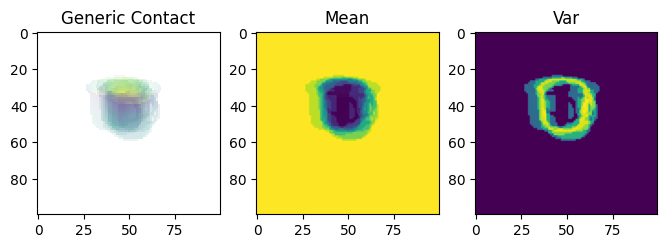

In [25]:
inds = jnp.array([13])
generic_ps, ws = generic_contact(key, _ps[0], n=10, sig_x=0.01, sig_hd=1.5)

# cam_x = jnp.array([0.0, -.7, 0.0])
cam_x = jnp.array([0.0, -.3, -0.5])
cam = b3d.transform_from_pos_target_up(cam_x, jnp.zeros(3), jnp.array([0.0,0.0,1.0]))


Ys = vmap(render, (None,0,None))(cam, generic_ps[:,None], inds)
print(Ys.shape)

# ==============================
fig, axs = plt.subplots(1,3, figsize=(8,3))
axs[0].set_title("Generic Contact")
for Y in Ys: axs[0].imshow(prep_im(Y), alpha=0.1, interpolation="nearest");
axs[1].set_title("Mean")
axs[1].imshow(np.mean(Ys, axis=0)[...,2], cmap="viridis");
axs[2].set_title("Var")
axs[2].imshow(np.var(Ys, axis=0)[...,2], cmap="viridis");

## Test Cases

In [48]:
tests = []

### 1

(2, 4, 4) (2,)


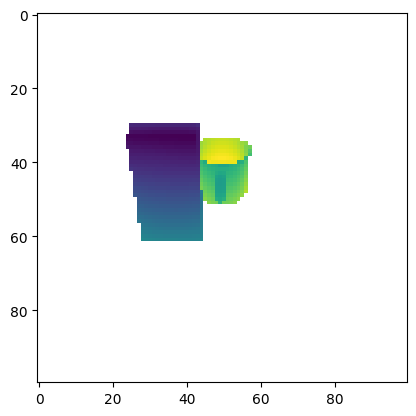

In [49]:
# Place a camera
cam_x = jnp.array([0.0, -0.5, -.75])
_cam = b3d.transform_from_pos_target_up(cam_x, jnp.zeros(3), jnp.array([0.0,-1.0,0.0]))

# Make a scene (centered at the origin)
_inds = jnp.array([13,2])
_vs   = jnp.array([
    [0.0, 0.0, jnp.pi],
    [-0.075, -0.1, 0.0*jnp.pi]
])
_ps = make_table_scene(_inds, _vs)
print(_ps.shape, _inds.shape)
_X = render(_cam, _ps, _inds)


tests.append(
    (_X, _cam, _ps, _inds, _vs)
)
    

# =====================
plt.imshow(prep_im(_X))

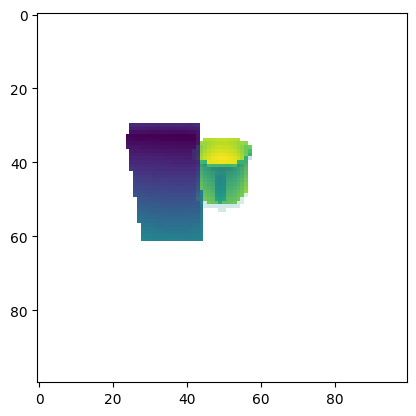

In [50]:
p = pose_from_contact(13, jnp.array([0.0,0.01,0.0*jnp.pi]))
Y = render(_cam, p, jnp.array([13]))

# =====================
plt.imshow(prep_im(_X))
plt.imshow(prep_im(Y), alpha=0.2)

In [51]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

## Score

In [102]:
def score_independent(X, Ys, log_ws, sig, outl, zmax):
    
    log_ws = log_ws - logsumexp(log_ws)
    diffs  = X[None,...,2] - Ys[...,2]

    inl_logps  = normal_logpdf(diffs, loc=0.0, scale=sig)     
    outl_logps = jnp.where(diffs <= 0, jnp.log(1./zmax), jnp.log(1./zmax))
    logps      = jnp.logaddexp(jnp.log(1.0-outl) + inl_logps, jnp.log(outl) + outl_logps)

    logps = logsumexp(logps + log_ws[:,None,None], axis=0)
    logp  = logps.sum()
    
    return logp


def score_dependent(X, Ys, log_ws, sig, out, zmax):
    
    log_ws = log_ws - logsumexp(log_ws)
    diffs  = X[None,...,2] - Ys[...,2]

    inl_logps  = normal_logpdf(diffs, loc=0.0, scale=sig)     
    outl_logps = jnp.where(diffs <= 0, jnp.log(1./zmax), jnp.log(1./zmax))
    logps      = jnp.logaddexp(jnp.log(1.0-outl) + inl_logps, jnp.log(outl) + outl_logps)

    logps = logps.sum((1,2))
    logp  = logsumexp(logps + log_ws)

    return logp


In [98]:
inds = jnp.array([13])
v0   = jnp.array([0.0,0.0,0.5*jnp.pi])
generic_ps, log_ws = generic_contact(key, inds[0], v0, n=64, sig_x=0.01, sig_hd=0.01)
generic_ps, log_ws = generic_ps[1:], log_ws[1:]
Ys = vmap(render, (None,0,None))(cam, generic_ps, inds)

print(_X.shape, Ys.shape, log_ws.shape)
sig  = 0.01
out  = 0.1
zmax = 3.0

scs = score_pair(_X, Ys, log_ws, sig, out, zmax)
sc  = score_pair2(_X, Ys, log_ws, sig, out, zmax)
scs.sum(), sc

(64, 3)
(100, 100, 3) (63, 100, 100, 3) (63,)


(Array(31585.785, dtype=float32), Array(31596.957, dtype=float32))

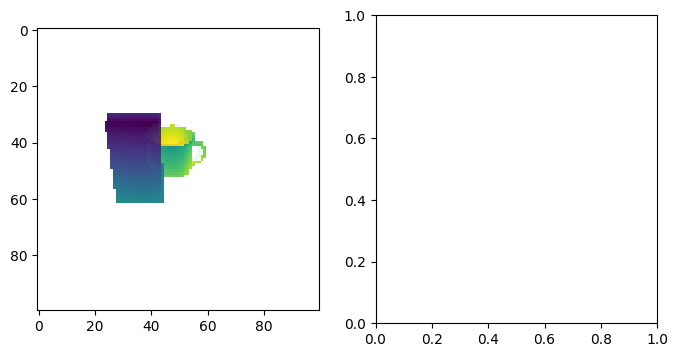

In [99]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(prep_im(_X), interpolation="nearest")
axs[0].imshow(prep_im(Ys[0]), alpha=.1, interpolation="nearest")

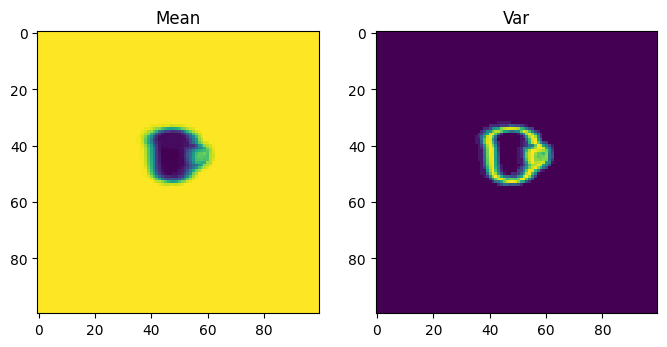

In [100]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].set_title("Mean")
axs[0].imshow(jnp.mean(Ys[...,2], axis=0), interpolation="nearest")
axs[1].set_title("Var")
axs[1].imshow(jnp.var(Ys[...,2], axis=0), interpolation="nearest")

In [101]:
w = 8
im = Ys.reshape((w,w,100,100,3))
im = jax.numpy.transpose(im, [2,0,3,1,4])
im = im.reshape((w*100,w*100,3))
plt.figure(figsize=(4,4))
plt.imshow(prep_im(im), interpolation="nearest")

TypeError: reshape total size must be unchanged, got new_sizes (8, 8, 100, 100, 3) for shape (63, 100, 100, 3).

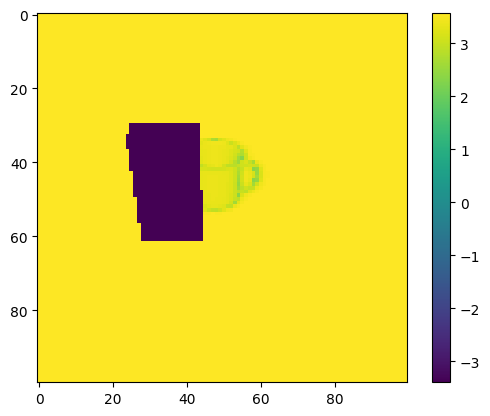

In [ ]:
plt.imshow(scs)
plt.colorbar()

In [47]:
def score_pair(X, Y, sig, out, zmax):
    
    diffs = X[...,2] - Y[...,2]

    in_logps  = normal_logpdf(diffs, loc=0.0, scale=sig) 
    # out_logps = normal_logpdf(diffs, loc=0.0, scale=zmax) 
    # out_logps = jnp.log(1.0/zmax)*jnp.ones_like(in_logps)
    out_logps = jnp.where(diffs <= 0, jnp.log(2.0/zmax), jnp.log(0.5/zmax))

    logps = jnp.logaddexp(jnp.log(1.0-out) + in_logps, jnp.log(out) + out_logps)

    return logps.sum()


27761.967
31424.926
31429.531
30624.293
29137.531


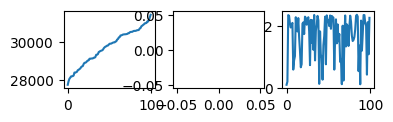

In [48]:
sig  = 0.01
out  = 0.1
zmax = 4.0

ps, indices = make_table_scene(jnp.array([13]), jnp.array([[0.02, -0.02, 0.7*jnp.pi]]))

key = keysplit(key)
Ys, logps = jgeneric_imgs(key, cam, ps, indices, n=100, sig_x=0.05, sig_r=0.3)

scs   = vmap(score_pair, (None,0,None,None,None))(X,Ys,sig,out,zmax)
order = jnp.argsort(scs)

print(scs[order[0]])
print(logsumexp(scs - jnp.log(len(scs))))
print(scs[order[-1]])
print(scs[0])
print(scs[-1])


# ========================
fig, axs = plt.subplots(1,3,figsize=(4,1))
axs[0].plot(scs[order])
axs[1].plot(jnp.exp(scs[order])) 
# axs[0].hlines(logsumexp(scs+logps), 0, len(scs))
axs[2].plot(jnp.exp(logps)[order]);

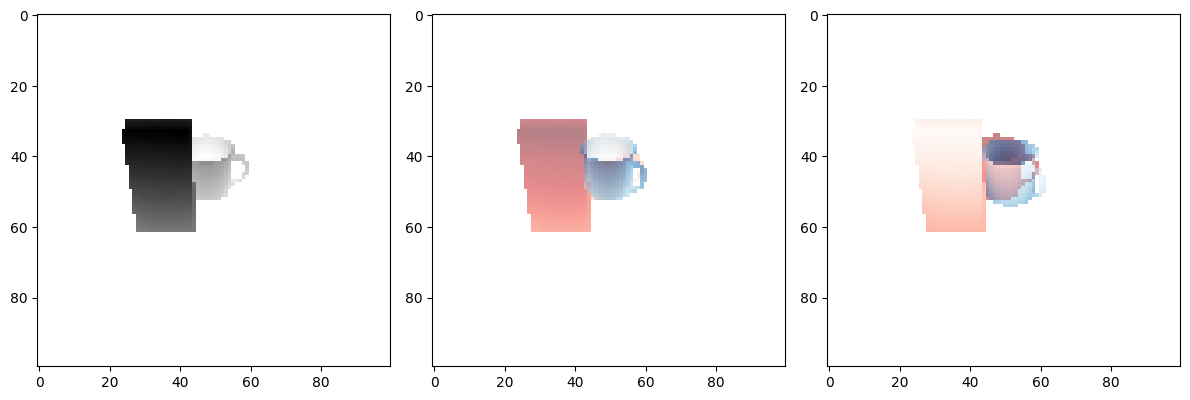

In [24]:
# =============================
fig, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].imshow(prep_im(X), cmap="binary_r")
axs[1].imshow(prep_im(X), alpha=.5, cmap="Reds_r")
axs[1].imshow(prep_im(Ys[order[-1]]), alpha=0.5, cmap="Blues_r")
axs[2].imshow(prep_im(X), alpha=.5, cmap="Reds")
axs[2].imshow(prep_im(Ys[0]), alpha=0.5, cmap="Blues")
fig.tight_layout()

[[34 45]
 [35 25]
 [44 56]
 [49 51]
 [45 38]
 [34 45]
 [45 38]
 [45 38]]


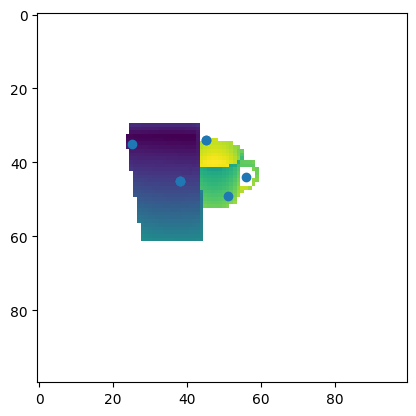

In [40]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

# img1 = rgb2gray(data.astronaut())
# img2 = transform.rotate(img1, 180)
# tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
#                                   translation=(0, -200))
# img3 = transform.warp(img1, tform)

Y = X
# Y = Ys[0]
im = Y[...,2]
descriptor_extractor = SIFT()
descriptor_extractor.detect_and_extract(im)
kpts = descriptor_extractor.keypoints
print(kpts)
plt.imshow(prep_im(Y))
plt.scatter(kpts[:,1],kpts[:,0])



## Observation Scorer

In [24]:
def dslice(X, i, j, w):     
    m = 2*w + 1
    return  jax.lax.dynamic_slice(X, (i, j, 0), (m, m, 3))   

In [25]:
def diffs(i, j, X, Y, w):
    xs = dslice(X[...,:3], i, j, w).reshape(-1,3)
    ys = dslice(Y[...,:3], i, j, w).reshape(-1,3)
    x = X[i+w,j+w,:3] 
    y = Y[i+w,j+w,:3]
    
    return jnp.min(jnp.linalg.norm(x - ys, axis=-1)/x[2]), jnp.min(jnp.linalg.norm(y - xs, axis=-1)/y[2])


In [26]:
def _scorer(X, Y, sig, out, zmax, w):

    shape = (Y.shape[0]-2*w, Y.shape[1]-2*w)

    I, J  = jnp.mgrid[:shape[0], :shape[1]]
    I, J  = I.ravel(), J.ravel()

    dx, dy = vmap(diffs, (0,0,None,None,None))(I,J,X,Y,w)

    xlogps = normal_logpdf(dx, 0.0, sig)
    ylogps = normal_logpdf(dy, 0.0, sig)

    outl_map = jnp.log(1-out) + xlogps <=  jnp.log(out) + jnp.log(1/zmax)

    ptw = jnp.where(outl_map,
                jnp.log(out)   + jnp.log(1/zmax),
                jnp.log(1-out) + jnp.logaddexp(jnp.log(0.5) + xlogps, jnp.log(0.5) + ylogps),
    )

    # ptw = jnp.where(outl_map,
                # jnp.log(out)   + jnp.log(1/zmax),
                # jnp.log(1-out) + xlogps,
    # )

    return ptw.sum(), ptw.reshape(shape), outl_map.reshape(shape)


args = Args(
    sig  = 0.005,
    out  = 0.1,
    zmax = 2.0,
    w    = 3
)
_scorer(X0, X1, *args);

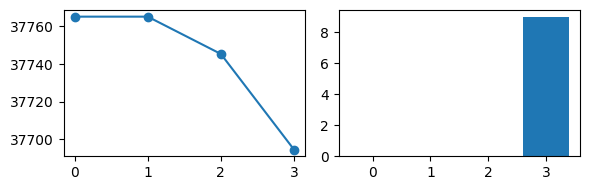

In [27]:
logps = []
ptws  = []
outls = []
for X,Y in [(X0,X0), (X1,X1), (X0,X1), (X1,X0)]:

    logp, ptw, outl = _scorer(X,Y, *args)

    logps.append(logp)
    ptws.append(ptw)
    outls.append(outl)

logps = jnp.array(logps)
ptws  = jnp.array(ptws)
outls = jnp.array(outls)


# ============================================
fig, axs = plt.subplots(1,2,figsize=(6,2))
axs[0].plot(logps, marker="o")
axs[1].bar(jnp.arange(len(logps)),outls.sum((-1,-2)))
fig.tight_layout()

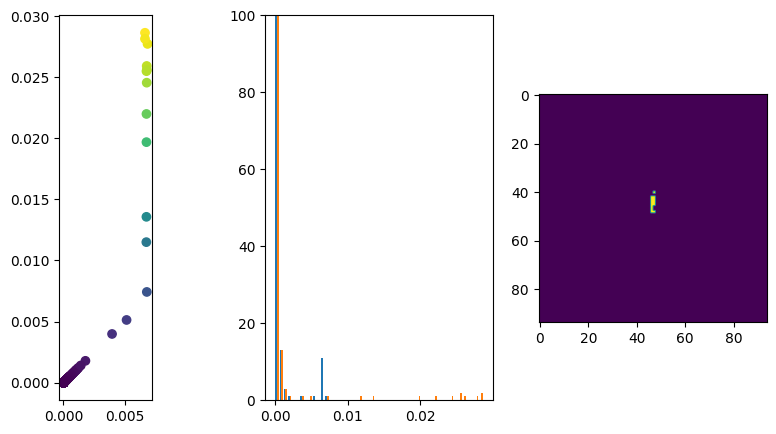

In [39]:
w    = 3
sig  = 0.001
out  = 0.1
zmax = 2.0


shape = (Y.shape[0]-2*w, Y.shape[1]-2*w)

I, J  = jnp.mgrid[:shape[0], :shape[1]]
I, J  = I.ravel(), J.ravel()

dx, dy = vmap(diffs, (0,0,None,None,None))(I,J,X0, X1,w)
Dx = dx.reshape(shape)
Dy = dy.reshape(shape)

xlogps = normal_logpdf(dx, 0.0, sig)
ylogps = normal_logpdf(dy, 0.0, sig)
outl_map = jnp.log(1-out) + xlogps <=  jnp.log(out) + jnp.log(1/zmax)
outl_map = outl_map.reshape(shape)


# ---------------------------------
fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].set_aspect(1)
axs[0].scatter(dx, dy, c=dy)
axs[1].set_ylim(0,100)
axs[1].hist([dx,dy], bins=50);
axs[2].imshow(jnp.concatenate([Dx,Dy], axis=1))
axs[2].imshow(outl_map)

In [43]:
def get_projections_and_distances(x, ys):
    """Returns projections and distances of y's on and to ray through x."""
    
    z   = jnp.linalg.norm(x, axis=-1)
    zs_ = jnp.linalg.norm(ys, axis=-1)

    # Projections ONTO ray through `x`
    ys_ = ys @ x / z
    
    # Distances TO ray through `x`
    ds_ = jnp.linalg.norm(ys_[:,None] * x / z - ys, axis=-1)

    return ys_, ds_

In [44]:
def get_1d_mixture_components_b(x, ys, sig):
    """Returns 1d mixture components and thier unnormalized weights."""

    # Projections serve as 1d mixture components and 
    # distances will be turned into appropriate weights
    ys_, ds_ = get_projections_and_distances(x, ys)    

    # Transform weights appropriately.
    ws_  = normal_logpdf(ds_, loc=0.0, scale=sig) + normal_logpdf(0.0, loc=0.0, scale=sig)

    return ys_, ws_

In [45]:
# def _score_ij(i,j, X, Y, sig, out, zmax, w):

#     ys = dslice(Y[...,:3], i, j, w).reshape(-1,3)
#     x = X[i+w,j+w,:3] 
#     ys_, ws_ = get_1d_mixture_components_b(x, ys, sig)

#     jnp.argsort(ys_)


# def _scorer2(X, Y, sig, out, zmax, w):

#     shape = (Y.shape[0]-2*w, Y.shape[1]-2*w)

#     I, J  = jnp.mgrid[:shape[0], :shape[1]]
#     I, J  = I.ravel(), J.ravel()

#     # dx, dy = vmap(diffs, (0,0,None,None,None))(I,J,X,Y,w)

#     get_1d_mixture_components_b(x, ys, sig)

#     xlogps = normal_logpdf(dx, 0.0, sig)




# args = Args(
#     sig  = 0.005,
#     out  = 0.1,
#     zmax = 2.0,
#     w    = 3
# )
# _scorer(X0, X1, *args);

nan


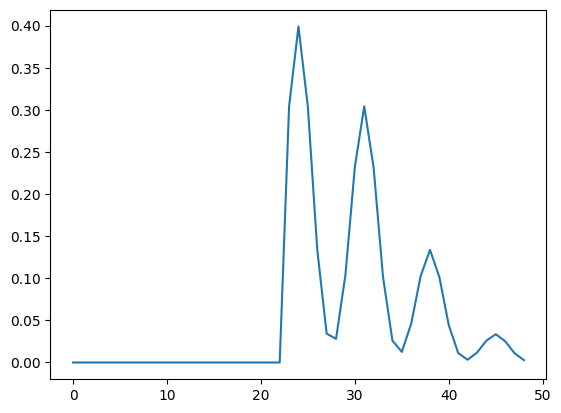

In [97]:

i,j = 35,45
w=3
sig=0.01
Y=X1
ys = dslice(Y[...,:3], i, j, w).reshape(-1,3)
x = X[i+w,j+w,:3] 
_, ds_ = get_projections_and_distances(x, ys)
ys_, ws_ = get_1d_mixture_components_b(x, ys, sig)

order = jnp.argsort(ys_)
ys_ = ys_[order]
ws_ = ws_[order]

o = jnp.sum(jnp.log(1.0 - jnp.exp(ws_)))
print(o)

plt.plot(sig*jnp.exp(normal_logpdf(ds_, loc=0.0, scale=sig)))

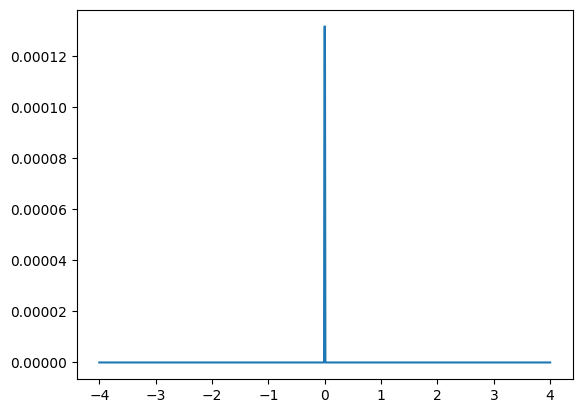

In [104]:
sig=0.001
xs = jnp.linspace(-4,4,1_000)
ys = vmap(lambda x: jnp.log(sig) + normal_logpdf(x, loc=0.0, scale=sig))(xs)
plt.plot(xs,jnp.exp(ys))

In [160]:
_far

10.0

1.0212488 10.0
1.0310653 10.918791


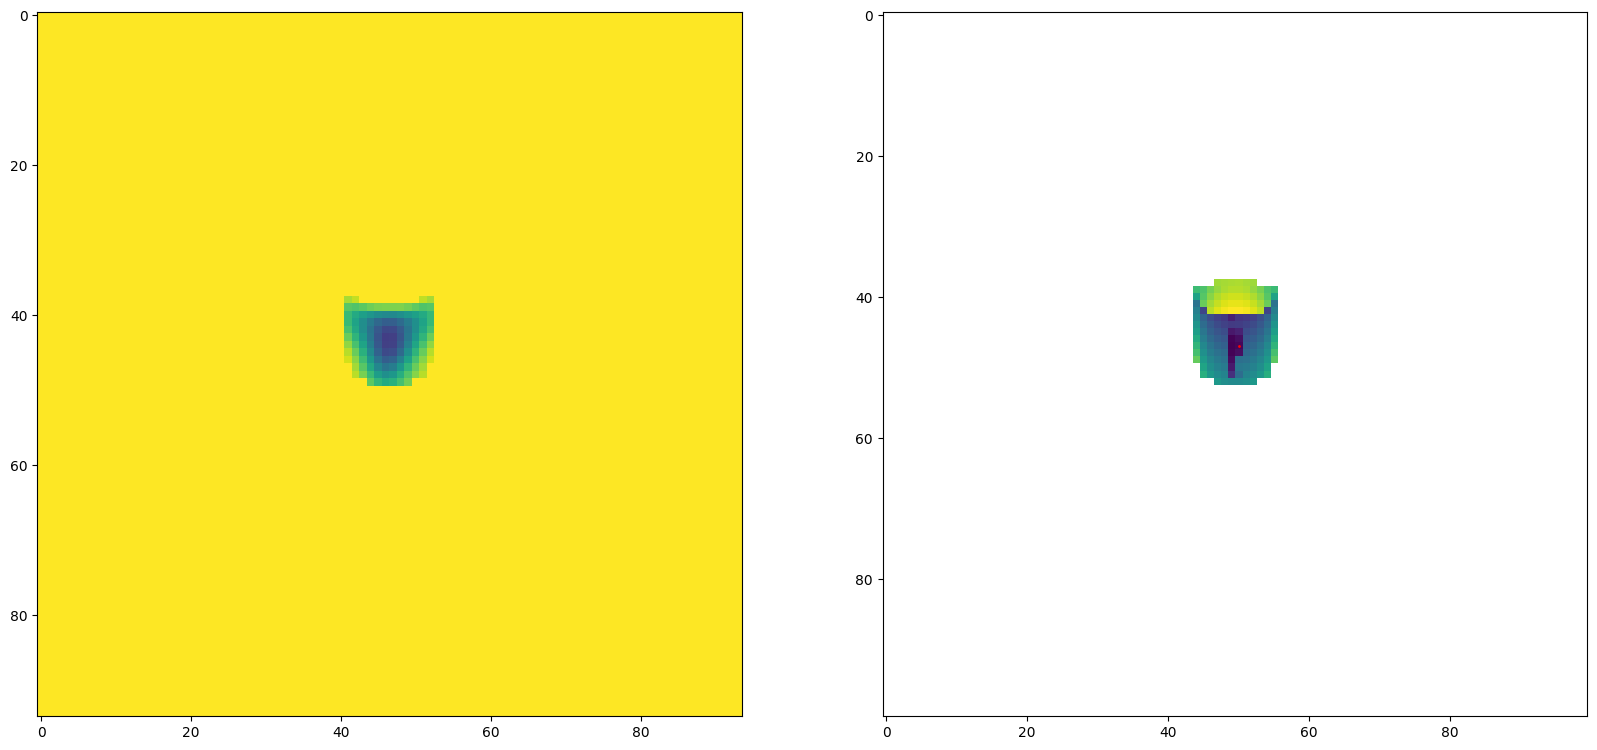

In [304]:

def _opacity(i,j,Y,w,sig):
    ys = dslice(Y[...,:3], i, j, w).reshape(-1,3)
    x = X[i+w,j+w,:3] 
    ys_, ws_ = get_1d_mixture_components_b(x, ys, sig)

    order = jnp.argsort(ys_)
    ys_ = ys_[order]
    ws_ = ws_[order]
    ps_ = sig**2*jnp.exp(ws_)
    ps_ = jnp.concatenate([jnp.array([0.0]),ps_])
    ps_ = jnp.cumprod(1.0-ps_[:-1])*ps_[1:]
    ps_ = ps_/jnp.sum(ps_)
    o = jnp.sum(ps_*ys_)
    return o



opacity = vmap(_opacity, (0,0,None,None,None))
w   = 3
sig = 0.01
Y = X1

print(jnp.min(Y[...,2]),jnp.max(Y[...,2]))
shape = (Y.shape[0]-2*w, Y.shape[1]-2*w)

I, J  = jnp.mgrid[:shape[0], :shape[1]]
I, J  = I.ravel(), J.ravel()
im = opacity(I, J, Y, w, sig).reshape(shape)
print(jnp.min(im), jnp.max(im))

# plt.xlim(1,1.2)
# plt.ylim(-12_000,0)
# plt.scatter(ys_,ws_)

i_, j_= 47, 50


fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].imshow(im, vmin=1.02, vmax=1.08)
axs[1].imshow(prep_im(Y))
axs[1].scatter(j_,i_, c="r", s=1)

81
81


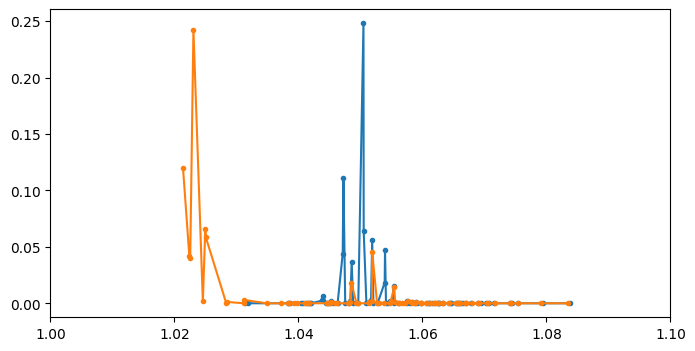

In [358]:
w   = 4
sig = 0.005
Y = X0

i = i_ - w
j = j_ - w

ys = dslice(Y[...,:3], i, j, w).reshape(-1,3)
x = X[i+w,j+w,:3] 
ys_, ws_ = get_1d_mixture_components_b(x, ys, sig)

order = jnp.argsort(ys_)
ys_ = ys_[order]
ws_ = ws_[order]

ps_ = ws_
ps_ = jnp.exp(ws_)
ps_ = ps_/jnp.sum(ps_)
ps_ = jnp.concatenate([jnp.array([0.0]),ps_])
ps_ = jnp.cumprod(1.0-ps_[:-1])*ps_[1:]
# ps_ = ps_/jnp.sum(ps_)
# ps_ = ps_/jnp.sum(ps_)
# o = jnp.sum(ps_*ys_)

print(len(ys_))



plt.figure(figsize=(8,4))
plt.xlim(1.,1.1)
plt.plot(ys_,ps_, marker=".")
# plt.vlines(jnp.linalg.norm(Y[i+w,j+w,:3]), jnp.min(ps_),jnp.max(ps_), color="b")


Y = X1


ys = dslice(Y[...,:3], i, j, w).reshape(-1,3)
x = X[i+w,j+w,:3] 
ys_, ws_ = get_1d_mixture_components_b(x, ys, sig)

order = jnp.argsort(ys_)
ys_ = ys_[order]
ws_ = ws_[order]

ps_ = ws_
ps_ = jnp.exp(ws_)
ps_ = ps_/jnp.sum(ps_)
ps_ = jnp.concatenate([jnp.array([0.0]),ps_])
ps_ = jnp.cumprod(1.0-ps_[:-1])*ps_[1:]
# ps_ = ps_/jnp.sum(ps_)
# ps_ = ps_/jnp.sum(ps_)
# o = jnp.sum(ps_*ys_)

print(len(ys_))




plt.plot(ys_, ps_, marker=".")
# plt.vlines(jnp.linalg.norm(Y[i+w,j+w,:3]), jnp.min(ps_),jnp.max(ps_), color="g")